In [57]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time

from matplotlib import pyplot as plt

from assembly_gym.envs.assembly_env import AssemblyEnv, Shape, Block
from assembly_gym.envs.gym_env import AssemblyGym, sparse_reward, tower_setup, bridge_setup, hard_tower_setup, Action

from assembly_gym.utils.geometry import align_frames_2d
from assembly_gym.utils.rendering import plot_assembly_env, render_assembly_env, plot_block_movements, plot_cra_assembly

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Assembly Environment

The assembly environment is a wrapper around the pybullet physics engine. It provides a simple interface to add blocks and obstacles to the environment.

The basic element is defined by `Shape` which loads the geometry from a urdf file. The `Shape` class provides an interface to compute relative coordinates for each of the faces or edges in 2d.
A `Block` is defined by a `Shape` and a position and orientation in 3d space.

In [2]:
# load shapes
trapezoid = Shape(urdf_file='shapes/trapezoid.urdf')
vblock = Shape(urdf_file='shapes/v_block.urdf')
cube = Shape(urdf_file='shapes/cube.urdf')
# cube = Shape(urdf_file='shapes/small_cube.urdf')
tblock = Shape(urdf_file='shapes/t_block.urdf')

trapezoid.num_faces_2d, trapezoid.urdf_file

(4,
 '/mydata/robotoddler/johannes/robotoddler-dev/assembly_gym/assembly_gym/../shapes/trapezoid.urdf')

In [3]:
env = AssemblyEnv(render=False, bounds=np.array([[-5., -5., -1], [5., 5., 9.]]), stability='rbe', cra_env=True, pybullet_env=True)

argv[0]=


## add one block and visualize the contact points


{'last_block': Block (1), 'collision': False, 'collision_info': {'obstacles': [], 'blocks': [], 'floor': False, 'bounding_box': False}, 'frozen_block': None, 'stable': True, 'stability_info': None}


Text(0.5, 1.0, 'CRA Assembly')

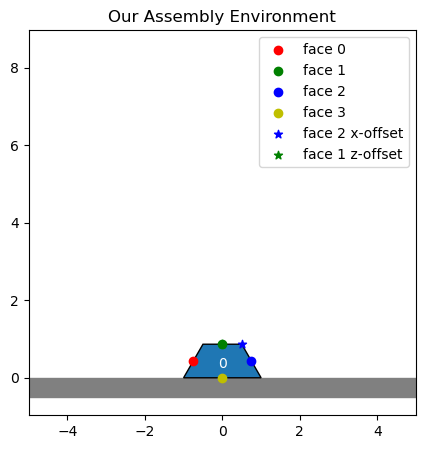

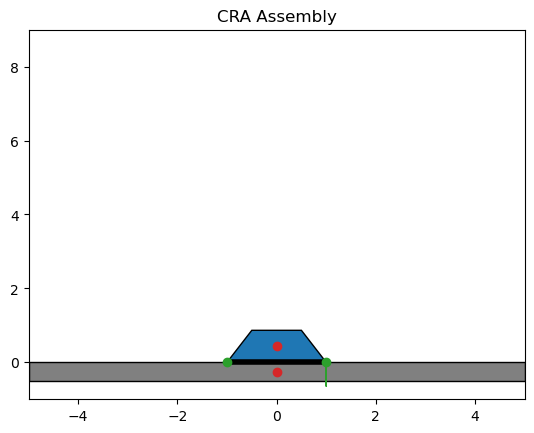

In [4]:
env.reset()
shape = trapezoid

# place first block on floor
position, rotation = align_frames_2d(env.get_floor_frame(), shape.get_face_frame_2d(face=3), frame1_coordinates=[0, 0, 0])

block1 = Block(shape=shape, position=position, orientation=rotation.quaternion)
print(env.add_block(block1))
fig, ax = plot_assembly_env(env, equal=True)


colors = ['r', 'g', 'b', 'y']
# plot contact point for all faces
for i in range(4):
    frame = block1.get_face_frame_2d(face=i)
    contact_point = frame.to_world_coordinates([0.0, 0, 0])
    ax.scatter([contact_point[0]], [contact_point[2]], label=f'face {i}', color=colors[i])

# shift the contact point  in frame coordinates
frame = block1.get_face_frame_2d(face=2)
contact_point = frame.to_world_coordinates([-0.5, 0, 0])
ax.scatter([contact_point[0]], [contact_point[2]], marker='*', label=f'face 2 x-offset', color=colors[2])

frame = block1.get_face_frame_2d(face=1)
contact_point = frame.to_world_coordinates([0.0, 0, 0.01])
ax.scatter([contact_point[0]], [contact_point[2]], marker='*', label=f'face 1 z-offset', color=colors[1])

ax.legend()
ax.set_title("Our Assembly Environment")
# env.client.resetDebugVisualizerCamera(cameraDistance=0.5, cameraYaw=0, cameraPitch=-40, cameraTargetPosition=[0.2,0,0])

fig, ax = plot_cra_assembly(env, plot_forces=True, plot_edges=False, force_scale=1)
ax.set_title("CRA Assembly")

None
{'last_block': Block (1), 'collision': False, 'collision_info': {'obstacles': [], 'blocks': [], 'floor': False, 'bounding_box': False}, 'frozen_block': None, 'stable': True, 'stability_info': None}


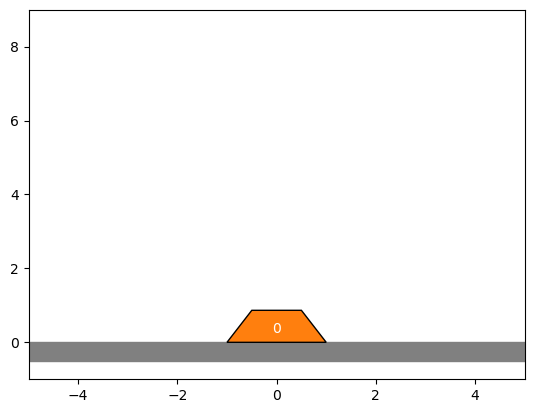

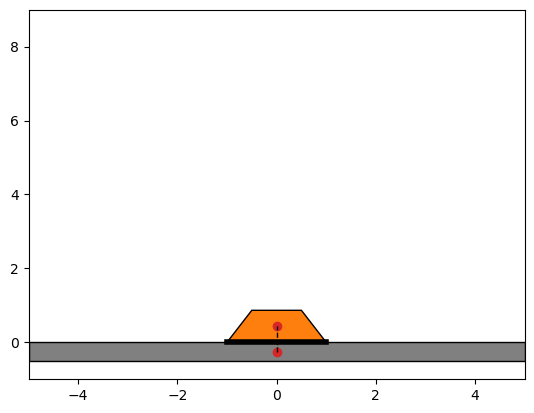

In [5]:
print(env.freeze_block(len(env.blocks)-1))
plot_assembly_env(env)
plot_cra_assembly(env, plot_forces=False, plot_edges=True, force_scale=1)
print(env.state_info)

{'last_block': Block (1), 'collision': False, 'collision_info': {'obstacles': [], 'blocks': [], 'floor': False, 'bounding_box': False}, 'frozen_block': None, 'stable': True, 'stability_info': None}


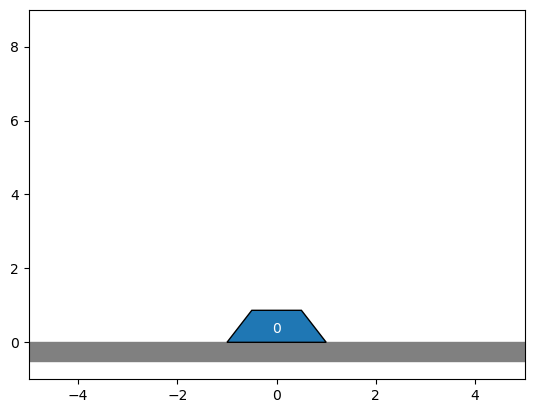

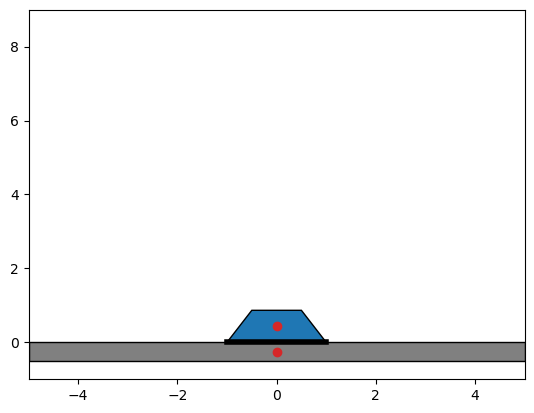

In [6]:
env.unfreeze_block(0)
plot_assembly_env(env)
plot_cra_assembly(env, plot_forces=False, plot_edges=False, force_scale=1)
print(env.state_info)

# next, we are adding two obstacles and two more blocks

{'last_block': Block (4), 'collision': False, 'collision_info': {'obstacles': [], 'blocks': [], 'floor': False, 'bounding_box': False}, 'frozen_block': None, 'stable': False, 'stability_info': None}
{'last_block': Block (5), 'collision': False, 'collision_info': {'obstacles': [], 'blocks': [], 'floor': False, 'bounding_box': False}, 'frozen_block': None, 'stable': True, 'stability_info': None}


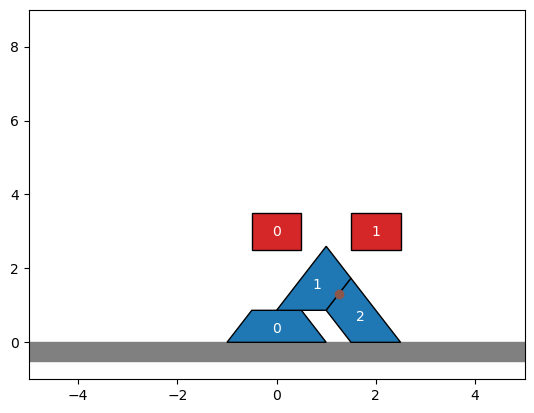

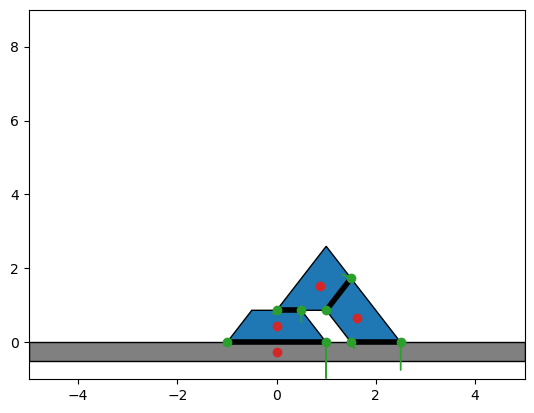

In [7]:
# add obstacles (shift them to create a collision)
env.add_obstacle(Block(shape=cube, position=[0, 0.0, 3]))
env.add_obstacle(Block(shape=cube, position=[2, 0.0, 3]))

# add second block
position, rotation = align_frames_2d(block1.get_face_frame_2d(face=1), trapezoid.get_face_frame_2d(face=2), frame1_coordinates=[0.5, 0., 0.])
block2 = Block(shape=trapezoid, position=position, orientation=rotation.quaternion)
print(env.add_block(block2))


# add third block
#contact point of block 2 (just for plotting):
p2 = block2.get_face_frame_2d(1).to_world_coordinates([-0.0, 0, 0])
position, rotation = align_frames_2d(block2.get_face_frame_2d(face=1), trapezoid.get_face_frame_2d(face=2), frame1_coordinates=[-0.0, 0.0, 0])
# position, rotation = align_frames_2d(env.get_floor_frame(), trapezoid.get_face_frame_2d(2), frame1_coordinates=[0.2, 0.0, 0])
block3 = Block(shape=trapezoid, position=position, orientation=rotation.quaternion)
print(env.add_block(block3))

# # add another block on the floor, in a collision position
# position, rotation = align_frames_2d(env.get_floor_frame(), trapezoid.get_face_frame_2d(face=2), frame1_coordinates=[0.45, 0.0, -0.01])
# block4 = Block(base_block=trapezoid, position=position, orientation=rotation.quaternion)
# print(env.add_block(block4))

fig, ax = plot_assembly_env(env)
ax.scatter([p2[0]], [p2[2]])

fig, ax = plot_cra_assembly(env, plot_forces=True, plot_edges=False, force_scale=1)

In [8]:
env.restore()
# env.client.resetDebugVisualizerCamera(cameraDistance=0.5, cameraYaw=0, cameraPitch=-40, cameraTargetPosition=[0.2,0,0])

In [9]:
# simulate the environment

env.restore()
time.sleep(1)
env.restore()
# start_time = time.time()
# max_time = 3
# while True:
#     env.realtime()
#     if time.time() - start_time > max_time:
#         break

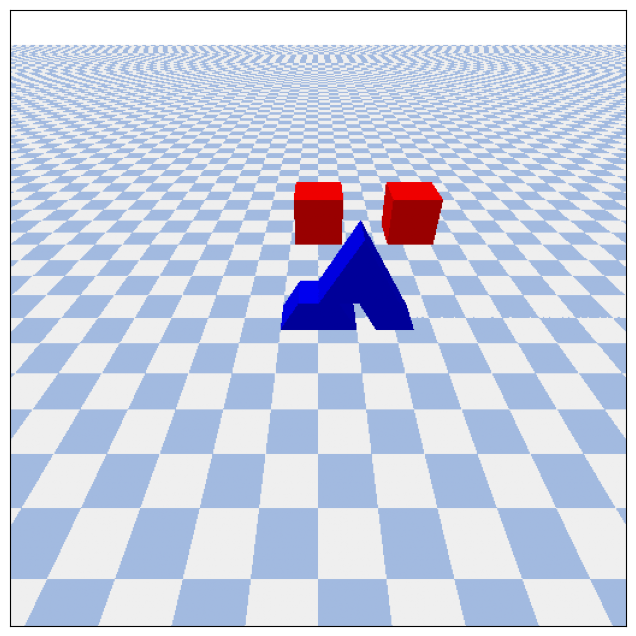

In [10]:
# render 3d view
fig, ax = render_assembly_env(near=0.1, fov=80, far=100, target=[0.0, 0, 0], distance=10.)

In [11]:
#  disconnect
env.disconnect_client()

# 2 AssemblyGym

The `AssemblyGym` class is a gym environment based on the `AssemblyEnv`.
It is defined by a set of available shapes, a set of obstacles, a set of targets, and a reward function.

## Tower setup

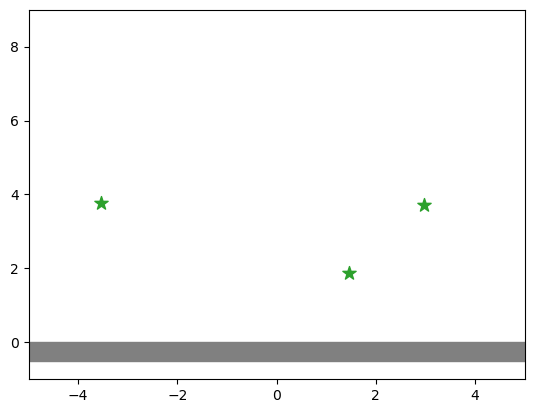

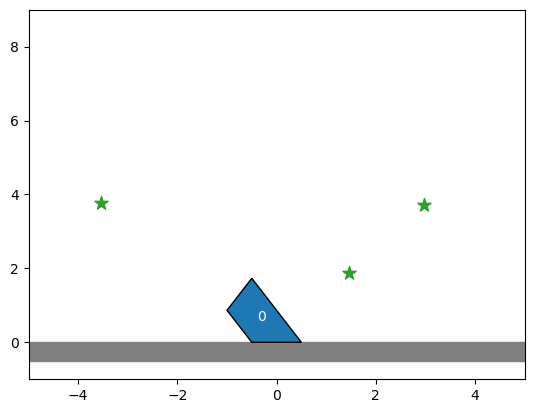

In [12]:
env = AssemblyGym(**tower_setup(), 
                  reward_fct=sparse_reward,
                  restrict_2d=True, 
                  assembly_env=AssemblyEnv(render=False))
plot_assembly_env(env)

action = Action(target_block=-1, target_face=1, shape=0, face=0, offset_x=0, offset_y=0)

obs, _, _, _, info = env.step(action)
plot_assembly_env(env)

env.assembly_env.disconnect_client()

## Bridge Setup

argv[0]=


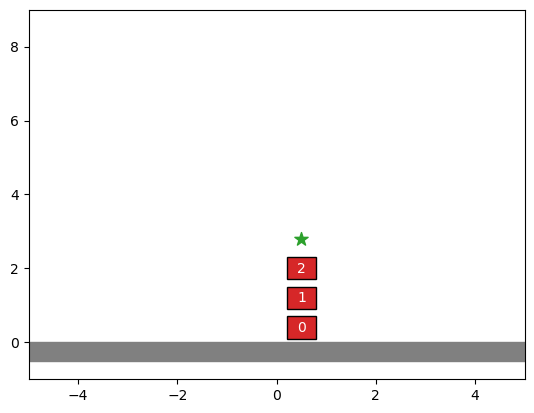

In [2]:
env = AssemblyGym(**bridge_setup(num_stories=3), 
                  reward_fct=sparse_reward,
                  restrict_2d=True, 
                  assembly_env=AssemblyEnv(render=False, pybullet_env=True))
plot_assembly_env(env)
env.assembly_env.client.resetDebugVisualizerCamera(cameraDistance=5, cameraYaw=0, cameraPitch=-40, cameraTargetPosition=[0.2,0,0])

## Bridge Demonstration

argv[0]=
Stable: True, Frozen Block: None, Collision: False, Targets Reached: 0
Reward: -1, Terminated: False, Truncated: None
--------------------------------------------------
Stable: True, Frozen Block: None, Collision: False, Targets Reached: 0
Reward: -1, Terminated: False, Truncated: None
--------------------------------------------------
Stable: True, Frozen Block: None, Collision: False, Targets Reached: 0
Reward: -1, Terminated: False, Truncated: None
--------------------------------------------------
Stable: True, Frozen Block: None, Collision: False, Targets Reached: 0
Reward: -1, Terminated: False, Truncated: None
--------------------------------------------------
Stable: True, Frozen Block: None, Collision: False, Targets Reached: 0
Reward: -1, Terminated: False, Truncated: None
--------------------------------------------------
Stable: True, Frozen Block: None, Collision: False, Targets Reached: 0
Reward: -1, Terminated: False, Truncated: None
----------------------------

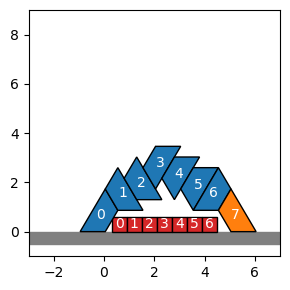

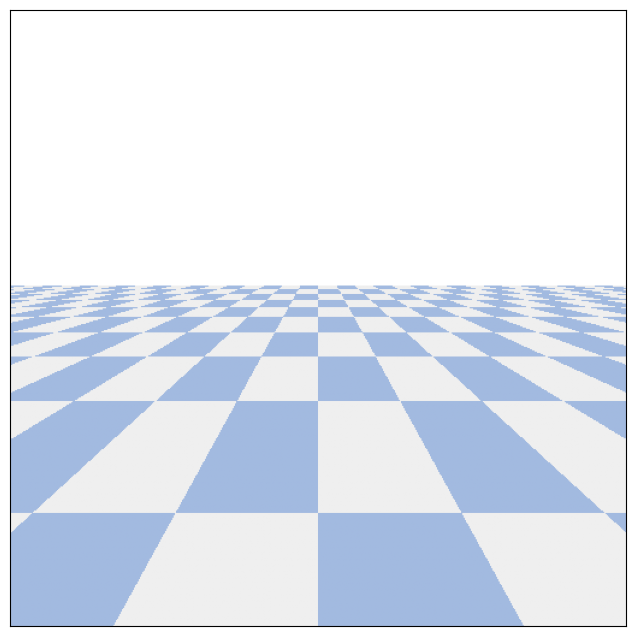

In [72]:
from assembly_gym.envs.gym_env import horizontal_bridge_setup


def print_step_info(obs, reward, terminated, truncated, info):
    # Print stable, frozen, collision, and targets reached in one line
    print(f"Stable: {obs['stable']}, Frozen Block: {obs['frozen_block']}, Collision: {obs['collision']}, Targets Reached: {len(obs['targets_reached'])}")
    
    # Print reward and termination in the next lines
    print(f"Reward: {reward}, Terminated: {terminated}, Truncated: {truncated}")
    print("--------------------------------------------------")


env = AssemblyGym(**horizontal_bridge_setup(num_obstacles=7), 
                  
                  reward_fct=sparse_reward,
                  restrict_2d=True, 
                  assembly_env=AssemblyEnv(render=False, mu=2.0, pybullet_env=True))
env.reset()

# Single plot for the final state
fig, axis = plt.subplots(1, 1, figsize=(3, 3))

actions = [
    Action(target_block=-1, target_face=0, shape=0, face=2, offset_x=-0.45, offset_y=0, frozen=True),
    Action(target_block=0, target_face=0, shape=0, face=1, offset_x=0, offset_y=0, frozen=True),
    Action(target_block=1, target_face=3, shape=0, face=1, offset_x=0, offset_y=0, frozen=True),
    Action(target_block=2, target_face=3, shape=0, face=0, offset_x=0, offset_y=0, frozen=True),
    Action(target_block=3, target_face=3, shape=0, face=1, offset_x=0, offset_y=0, frozen=True),
    Action(target_block=4, target_face=3, shape=0, face=1, offset_x=0, offset_y=0, frozen=True),
    Action(target_block=5, target_face=3, shape=0, face=3, offset_x=0, offset_y=0, frozen=True),
    Action(target_block=6, target_face=1, shape=0, face=2, offset_x=0, offset_y=0, frozen=True),
]

for action in actions:
    obs, reward, terminated, truncated, info = env.step(action)
    print_step_info(obs, reward, terminated, truncated, info)

# Plot the final state
plot_assembly_env(env.assembly_env, fig=fig, ax=axis)
plt.tight_layout()
plt.show()

env.assembly_env.simulate()
render_assembly_env(distance=5, target=(0., 0, 0), pitch=-20)
env.assembly_env.reset()


## Hard Tower Setup

argv[0]=


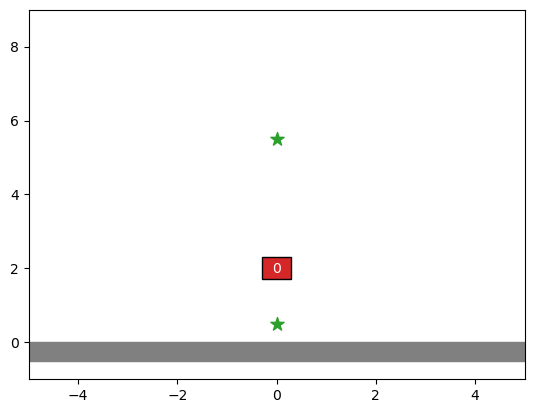

In [15]:
# create a new environment
env = AssemblyGym(**hard_tower_setup(),
                  reward_fct=sparse_reward,
                  restrict_2d=True, 
                  assembly_env=AssemblyEnv(render=False, pybullet_env=True))
plot_assembly_env(env)
env.assembly_env.client.resetDebugVisualizerCamera(cameraDistance=0.5, cameraYaw=0, cameraPitch=-40, cameraTargetPosition=[0.2,0,0])

({'blocks': [Block (2)], 'stable': True, 'collision': False, 'collision_block': False, 'collision_obstacle': False, 'collision_floor': False, 'collision_boundary': False, 'frozen_block': None, 'obstacles': [[0, 0, 2.0]], 'obstacle_blocks': [Block (1)], 'targets': [[0, 0, 0.5], [0, 0, 5.5]], 'targets_remaining': [[0, 0, 5.5]], 'targets_reached': [[0, 0, 0.5]], 'distance_to_targets': [0.0, 4.5]}, 0, False, None, {'blocks_initial_state': None, 'blocks_final_state': None})


(<Figure size 640x480 with 1 Axes>, <Axes: >)

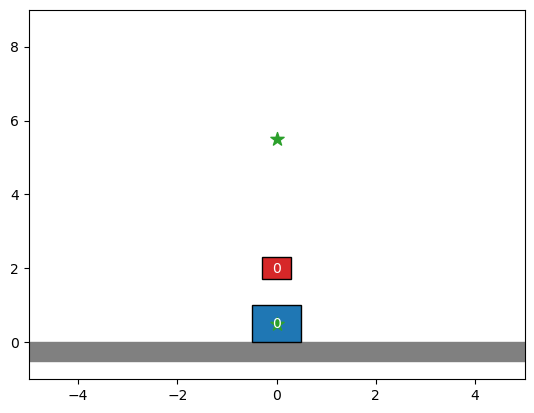

In [16]:
action = Action(-1, 0, 1, 0, 0, 0)

print(env.step(action))
plot_assembly_env(env)



({'blocks': [Block (2), Block (3)], 'stable': True, 'collision': False, 'collision_block': False, 'collision_obstacle': False, 'collision_floor': False, 'collision_boundary': False, 'frozen_block': None, 'obstacles': [[0, 0, 2.0]], 'obstacle_blocks': [Block (1)], 'targets': [[0, 0, 0.5], [0, 0, 5.5]], 'targets_remaining': [[0, 0, 5.5]], 'targets_reached': [[0, 0, 0.5]], 'distance_to_targets': [0.0, 4.5]}, 0, False, None, {'blocks_initial_state': None, 'blocks_final_state': None})
({'blocks': [Block (2), Block (3), Block (4)], 'stable': True, 'collision': False, 'collision_block': False, 'collision_obstacle': False, 'collision_floor': False, 'collision_boundary': False, 'frozen_block': None, 'obstacles': [[0, 0, 2.0]], 'obstacle_blocks': [Block (1)], 'targets': [[0, 0, 0.5], [0, 0, 5.5]], 'targets_remaining': [[0, 0, 5.5]], 'targets_reached': [[0, 0, 0.5]], 'distance_to_targets': [0.0, 4.5]}, 0, False, None, {'blocks_initial_state': None, 'blocks_final_state': None})
({'blocks': [Block 

(<Figure size 640x480 with 1 Axes>, <Axes: >)

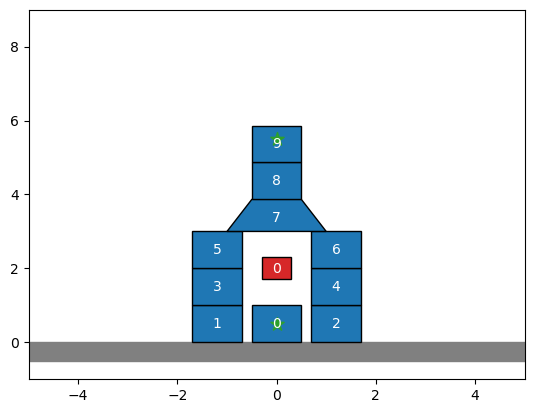

In [17]:
print(env.step(Action(target_block=-1, target_face=0, shape=1, face=0, offset_x=-1.2, offset_y=0)))
print(env.step(Action(target_block=-1, target_face=0, shape=1, face=0, offset_x=1.2, offset_y=0)))

print(env.step(Action(target_block=1, target_face=3, shape=1, face=0, offset_x=0., offset_y=0)))
print(env.step(Action(target_block=2, target_face=3, shape=1, face=0, offset_x=0., offset_y=0)))
print(env.step(Action(target_block=3, target_face=3, shape=1, face=0, offset_x=0., offset_y=0)))
print(env.step(Action(target_block=4, target_face=3, shape=1, face=0, offset_x=0., offset_y=0)))

# # trapezoid
print(env.step(Action(target_block=5, target_face=3, shape=0, face=3, offset_x=1.2, offset_y=0)))

print(env.step(Action(target_block=7, target_face=1, shape=1, face=0, offset_x=0., offset_y=0)))
print(env.step(Action(target_block=8, target_face=3, shape=1, face=0, offset_x=0., offset_y=0)))
# print(env.step(Action(target_block=9, target_face=2, shape=1, face=0, offset_x=0., offset_y=0)))

plot_assembly_env(env)

In [18]:
env.assembly_env.disconnect_client()